##Model3_FT - FineTuning using ConvNext

by Kaushik Srivatsan - CDS - kaushik.s-25@scds.saiuniversity.edu.in


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.15.0


## Loading the preprocessed dataset

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/Models/X_train_std_model3.npy')
X_test_std = load('/content/drive/MyDrive/Models/X_test_std_model3.npy')

y_train = load('/content/drive/MyDrive/Models/y_train_model3.npy')
y_test = load('/content/drive/MyDrive/Models/y_test_model3.npy')

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (373, 299, 299, 3)
X_test_std_shape: (125, 299, 299, 3)


##Loading the Transfer-learning Model

In [5]:
#Importing layers and stochastic depth to mitigate the export issue of keras with respect to the convnext model
from keras import layers

class StochasticDepth(layers.Layer):
    """Stochastic Depth module.

    It performs batch-wise dropping rather than sample-wise. In libraries like
    `timm`, it's similar to `DropPath` layers that drops residual paths
    sample-wise.

    References:
      - https://github.com/rwightman/pytorch-image-models

    Args:
      drop_path_rate (float): Probability of dropping paths. Should be within
        [0, 1].

    Returns:
      Tensor either with the residual path dropped or kept.
    """

    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"drop_path_rate": self.drop_path_rate})
        return config

class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

model3_FT = keras.models.load_model('/content/drive/MyDrive/Models/Model3_TL.h5',  compile=False, custom_objects={ "LayerScale": LayerScale, "StochasticDepth": StochasticDepth} )
model3_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 convnext_tiny_prestem_norm  (None, 299, 299, 3)          0         ['input_1[0][0]']             
 alization (Normalization)                                                                        
                                                                                                  
 convnext_tiny_stem (Sequen  (None, 74, 74, 96)           4896      ['convnext_tiny_prestem_normal
 tial)                                                              ization[0][0]']               
                                                                                              

## Modifyng and Fine tuning the layers to be trained

In [6]:

total_layers = len(model3_FT.layers)

for layer in model3_FT.layers[:total_layers]:
    layer.trainable = True

## Compiling and Training the Model

In [ ]:
model3_FT.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks_FineTune = [
             keras.callbacks.ModelCheckpoint("bestFT1.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history_FineTune = model3_FT.fit(x = X_train_std, y = y_train, epochs=10,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks_FineTune)

Epoch 1/10
21/21 [==============================] - 67s 1s/step - loss: 1.9656 - accuracy: 0.2985 - val_loss: 1.5590 - val_accuracy: 0.2895
Epoch 2/10
21/21 [==============================] - 12s 580ms/step - loss: 1.5465 - accuracy: 0.2955 - val_loss: 1.4817 - val_accuracy: 0.2895
Epoch 3/10
21/21 [==============================] - 12s 578ms/step - loss: 1.3995 - accuracy: 0.3194 - val_loss: 1.6463 - val_accuracy: 0.2895
Epoch 4/10
21/21 [==============================] - 12s 580ms/step - loss: 1.4010 - accuracy: 0.3313 - val_loss: 1.4727 - val_accuracy: 0.2895
Epoch 5/10
21/21 [==============================] - 12s 597ms/step - loss: 1.3879 - accuracy: 0.3493 - val_loss: 1.4326 - val_accuracy: 0.3158
Epoch 6/10
 5/21 [======>.......................] - ETA: 8s - loss: 1.3504 - accuracy: 0.3250

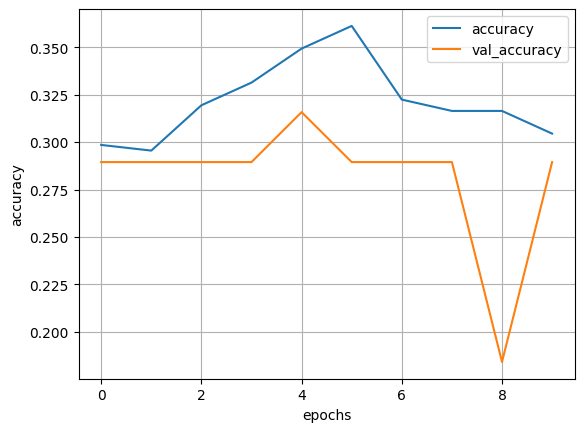

In [ ]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_FineTune.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

## Evaluating the Model with Best weights

In [ ]:
model3_FT.load_weights("bestFT1.h5")

testLoss_FineTune, testAccuracy_FineTune = model3_FT.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 8s 1s/step - loss: 1.4110 - accuracy: 0.2640
Test-loss: 1.411002, Test-accuracy: 0.264000


In [ ]:
## Checking Model performance

In [ ]:
y_proba = model3_FT.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

4/4 [==============================] - 4s 374ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


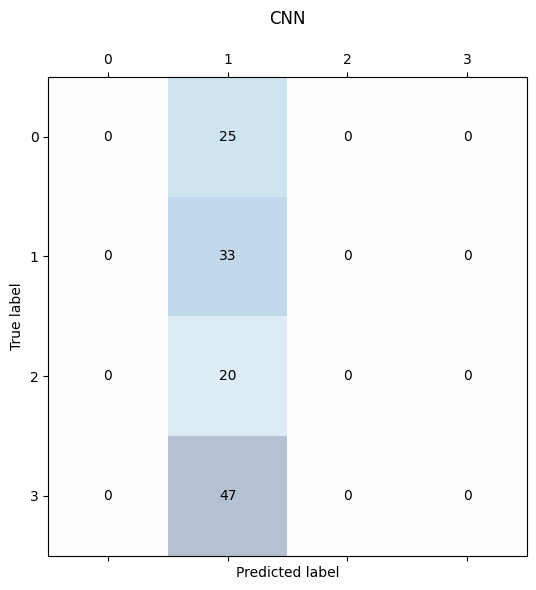

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.069696
Recall:  0.264
F1-score:  0.11027848101265823


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Saving the Fine-Tuned Model

In [ ]:
model3_FT.save('/content/drive/MyDrive/Models/model3_FT.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
